# Part 1. Preprocess stack of images: Denoise and Smooth edges

The aim of this preprocessing procedure was the application of state-of-the-art denoising techniques in image stacks derived from two HFMBs. Furthermore, another aim is the smoothing of the cross-sections of the fiber membranes was performed in order to secure accurate 3D bioreactor reconstruction. The pipeline pinpoints the most appropriate of these methods for each image stack, according to which method achieved the greatest reduction in Gaussian noise metrics. Then this method is applied to all the images in the stack.

The workflow of the procedure is detailed below in the example of "MELS01 left" stack of 400 images.

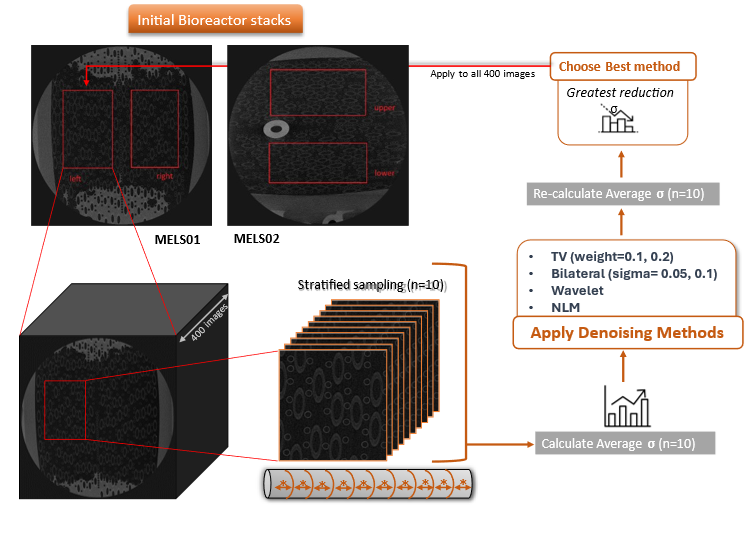

## Load Libraries

In [20]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.restoration import (
    denoise_tv_chambolle,
    denoise_bilateral,
    denoise_wavelet,
    estimate_sigma,
)
from skimage.io import imsave
import glob


## Provide input and output directories

In [ ]:
# Define paths for input and output folders
input_folder = 'example_path'  # Folder containing .tif images
output_folder = 'example_denoised'  # Folder for saving denoised images
visualization_folder = 'example_denoised_visualizations' # Path to save visualization graph of denoising methods in 3 random images
report_file = 'example_denoise_metrics_report.txt'  # Directory for saving denoise report

os.makedirs(output_folder, exist_ok=True)
os.makedirs(visualization_folder, exist_ok=True)
# Get all .tif images from the input folder
image_paths = sorted(glob.glob(os.path.join(input_folder, '*.tif'))) 


## Compute denoising metrics 

-Selects 10 random images using stratifed sampling (you can decide if you want to keep the sampling or use all images in the stack- sampling is recommended for efficiency)

-Computes the Gaussian standard deviation of the noise for each image before ("Original") and after each denoising method is applied

-Prints the results for each image

### Choose between sampling and using all images

In [ ]:

use_sampling = True # Set to True for sampling, False to use all images
num_samples = 10  # Number of samples if using sampling. 10 is recommended.

# If sampling is enabled, apply stratified sampling
if use_sampling:
    interval = len(image_paths) // num_samples
    sampled_image_paths = [random.choice(image_paths[i * interval:(i + 1) * interval]) for i in range(num_samples)]
else:
    sampled_image_paths = image_paths

### Application of methods and metrics calculation

In [ ]:

metrics = {
    "Original": [],
    "TV_0.1": [],
    "Bilateral_0.05": [],
    "Wavelet": [],
    "TV_0.2": [],
    "Bilateral_0.1": [],
    "NonLocalMeans": []
}

def apply_denoising_methods(image):
    denoise_results = {
        "TV_0.1": denoise_tv_chambolle(image, weight=0.1),
        "Bilateral_0.05": denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15),
        "Wavelet": denoise_wavelet(image, rescale_sigma=True),
        "TV_0.2": denoise_tv_chambolle(image, weight=0.2),
        "Bilateral_0.1": denoise_bilateral(image, sigma_color=0.1, sigma_spatial=15),
    }

    nlm_denoised = cv2.fastNlMeansDenoising(image, None, h=11, templateWindowSize=7, searchWindowSize=21)
    denoise_results["NonLocalMeans"] = nlm_denoised
    
    return denoise_results

def calculate_metrics(denoise_results):
    noise_metrics = {}
    for method, img in denoise_results.items():
        sigma_img_est = estimate_sigma(img, average_sigmas=True)
        metrics[method].append(sigma_img_est)
        noise_metrics[method] = sigma_img_est

    return noise_metrics

# Process each image in the selected list
for image_path in sampled_image_paths:

    #-------------------------------------------- !Note -----------------------------------------------------------#
    # This procedure is applied for greyscale images. For coloured the imread function and masks should be altered
    #--------------------------------------------------------------------------------------------------------------#

    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Calculate inherent noise in the original image
    original_sigma = estimate_sigma(original, average_sigmas=True)
    metrics["Original"].append(original_sigma)
    print(f"Inherent noise for {os.path.basename(image_path)}: {original_sigma}")

    #MASK APPLICATION:

    # Detect membrane structures using Otsu's thresholding
    _, mask = cv2.threshold(original, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the mask to isolate the ring structures
    mask = cv2.bitwise_not(mask)

    # Apply smoothing on membranes
    smoothed_rings = cv2.GaussianBlur(original, (15, 15), 0)

    # Apply the mask to smooth only the ring structures (keeping the background intact)
    masked_smoothing = cv2.bitwise_and(smoothed_rings, smoothed_rings, mask=mask)
    background = cv2.bitwise_and(original, original, mask=cv2.bitwise_not(mask))
    smoothed_image = cv2.add(masked_smoothing, background)

    # Apply denoising methods
    denoise_results = apply_denoising_methods(smoothed_image)

    # Calculate and store noise metrics for each denoising method
    noise_metrics = calculate_metrics(denoise_results)
    print(f"Metrics for {os.path.basename(image_path)}: {noise_metrics}")

# Compute average and standard deviation for each method
averages = {method: np.mean(values) for method, values in metrics.items()}
stddevs = {method: np.std(values) for method, values in metrics.items()}

Inherent noise for MELS02_upper0019.tif: 8.619408028386003
Metrics for MELS02_upper0019.tif: {'TV_0.1': 0.0004165011670860609, 'Bilateral_0.05': 0.010200982276808393, 'Wavelet': 0.0061080920314496336, 'TV_0.2': 0.00017718238348907658, 'Bilateral_0.1': 0.0043113338309958725, 'NonLocalMeans': 0.3458216754298268}
Inherent noise for MELS02_upper0096.tif: 8.586621292896629
Metrics for MELS02_upper0096.tif: {'TV_0.1': 0.000418020929056679, 'Bilateral_0.05': 0.009984910576162256, 'Wavelet': 0.00605259493384692, 'TV_0.2': 0.0001840170848597957, 'Bilateral_0.1': 0.0042347117122780754, 'NonLocalMeans': 0.3458216754298261}
Inherent noise for MELS02_upper0144.tif: 8.438952995880307
Metrics for MELS02_upper0144.tif: {'TV_0.1': 0.000418556791410077, 'Bilateral_0.05': 0.009944032955216009, 'Wavelet': 0.0056970881335692055, 'TV_0.2': 0.00016707690812229134, 'Bilateral_0.1': 0.004192388605301659, 'NonLocalMeans': 0.3458216754298234}
Inherent noise for MELS02_upper0257.tif: 8.316591233219633
Metrics for

## Find and print best method

In [ ]:

# Identify the best method --> lowest average Gaussian standard deviation of the noise
best_method = min(averages, key=averages.get)
print(f"Best denoising method: {best_method}")
print(f"Average noise metrics: {averages}")
print(f"Standard deviation of noise metrics: {stddevs}")

Best denoising method: TV_0.2
Average noise metrics: {'Original': 8.269955837403636, 'TV_0.1': 0.00037340007554365377, 'Bilateral_0.05': 0.009608118395747347, 'Wavelet': 0.005396921935334855, 'TV_0.2': 0.00016922666420829494, 'Bilateral_0.1': 0.004018866441171588, 'NonLocalMeans': 0.3291067478051942}
Standard deviation of noise metrics: {'Original': 0.2137743073241059, 'TV_0.1': 2.905717715416614e-05, 'Bilateral_0.05': 0.00036370907510398925, 'Wavelet': 0.0004391120825739724, 'TV_0.2': 6.005253485456278e-06, 'Bilateral_0.1': 0.0001857922355592673, 'NonLocalMeans': 0.011114487899873756}


## Save metrics in report file and print results for 3 random images

Inherent noise for MELS02_upper0324.tif: 8.2851


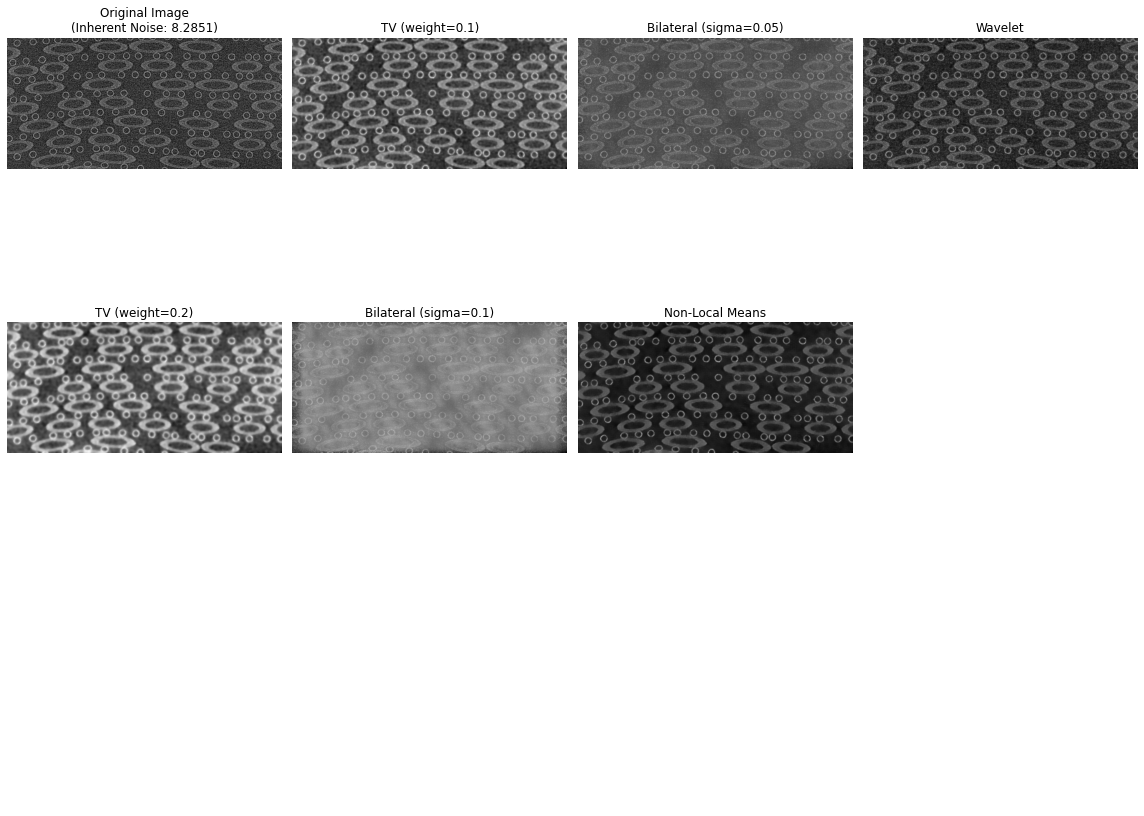

Inherent noise for MELS02_upper0519.tif: 8.0949


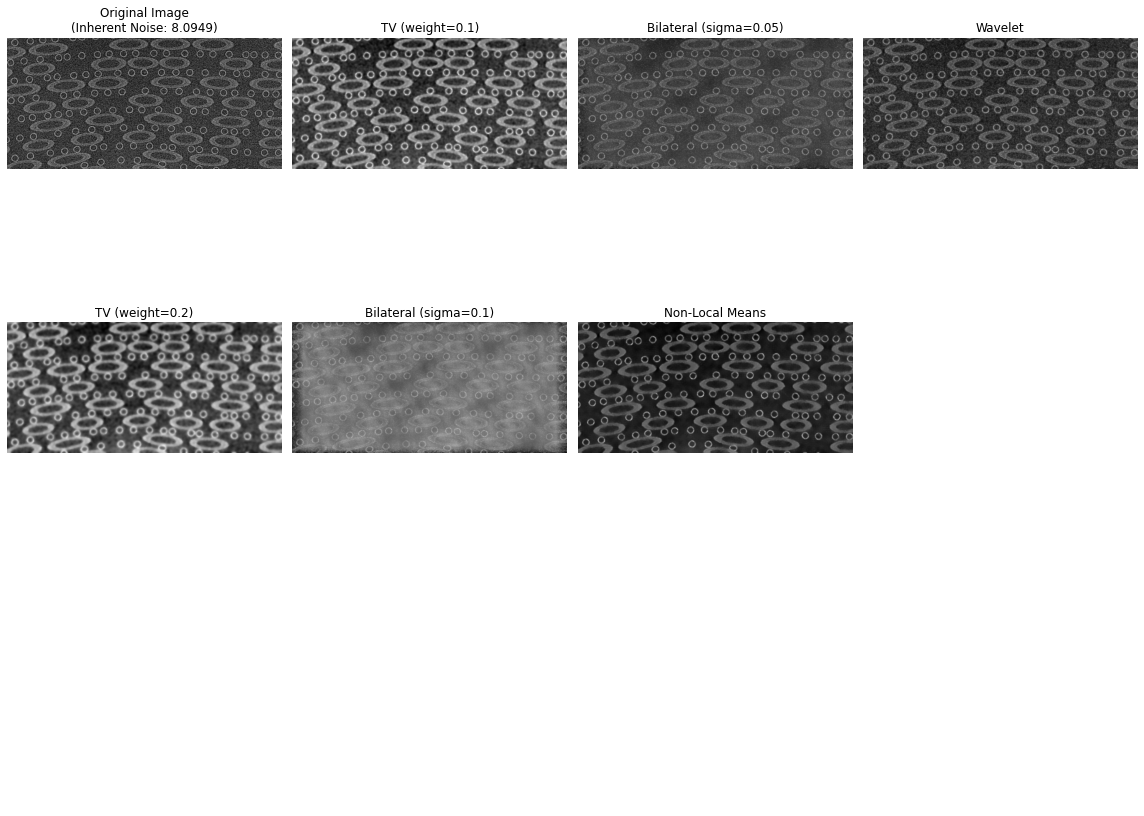

Inherent noise for MELS02_upper0000.tif: 8.6305


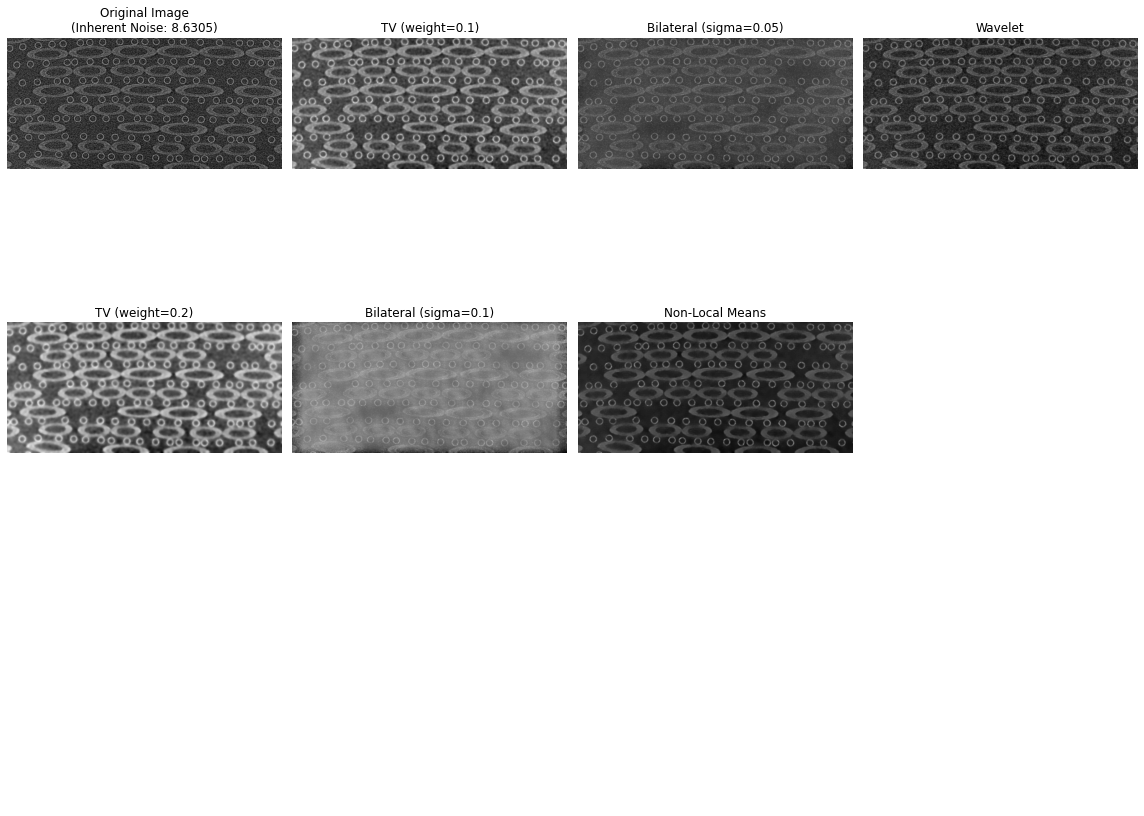

In [ ]:

with open(report_file, 'w') as report:
    report.write("Denoising Methods - Noise Metrics Report\n")
    report.write("=" * 50 + "\n")
    report.write(f"Best Denoising Method: {best_method}\n\n")

    inherent_noise_avg = np.mean(metrics["Original"])
    inherent_noise_stddev = np.std(metrics["Original"])
    report.write(f"Inherent Noise (Original Image):\n")
    report.write(f"Average: {inherent_noise_avg:.4f}\n")
    report.write(f"Standard Deviation: {inherent_noise_stddev:.4e}\n\n")

    report.write("Average Noise Standard Deviation for each method:\n")
    for method, avg in averages.items():
        report.write(f"{method}: {avg:.4f}\n")
    report.write("\nStandard Deviation of Noise for each method:\n")
    for method, stddev in stddevs.items():
        report.write(f"{method}: {stddev:.4e}\n")
    report.write("\n")

# Randomly select 3 images for visualization
selected_images = random.sample(image_paths, 3) # Change the "3" if you want more image examples to be printed

# Save and print visualizations of denoising results
for image_path in selected_images:
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    inherent_noise = estimate_sigma(original, average_sigmas=True)
    print(f"Inherent noise for {os.path.basename(image_path)}: {inherent_noise:.4f}")

    _, mask = cv2.threshold(original, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    mask = cv2.bitwise_not(mask)

    smoothed_rings = cv2.GaussianBlur(original, (15, 15), 0)

    masked_smoothing = cv2.bitwise_and(smoothed_rings, smoothed_rings, mask=mask)
    background = cv2.bitwise_and(original, original, mask=cv2.bitwise_not(mask))
    smoothed_image = cv2.add(masked_smoothing, background)

    denoise_results = apply_denoising_methods(smoothed_image)

    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 12)) 
    plt.gray()

    ax[0, 0].imshow(original, cmap='gray')
    ax[0, 0].axis('off')
    ax[0, 0].set_title(f'Original Image\n(Inherent Noise: {inherent_noise:.4f})')

    titles = [
        'TV (weight=0.1)', 'Bilateral (sigma=0.05)', 'Wavelet',
        'TV (weight=0.2)', 'Bilateral (sigma=0.1)', 'Non-Local Means'
    ]

    ax_flat = ax.flatten()

    for i, (name, img) in enumerate(denoise_results.items()):
        if i < 9:  
            ax_flat[i + 1].imshow(img, cmap='gray')
            ax_flat[i + 1].axis('off')
            ax_flat[i + 1].set_title(titles[i % len(titles)])

    for j in range(i + 2, 12):  
        ax_flat[j].axis('off')

    save_path = os.path.join(visualization_folder, f'visualization_{os.path.splitext(os.path.basename(image_path))[0]}.png')
    fig.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()

## Choose the final method you like or use best method based on results

In [ ]:

# Available denoising methods (you should manually set this variable)
# Choose one of the following, or type 'best' (recommended) to use the best method:
# 'TV_0.1', 'Bilateral_0.05', 'Wavelet', 'TV_0.2', 'Bilateral_0.1', 'NonLocalMeans', 'best'
chosen_method = 'best'  # <--- Set to 'best' to use the best method, or pick a specific method from above


## Apply chosen method on the stack of images

In [ ]:
# Determine which method to apply based on user input
if chosen_method == 'best':
    chosen_method = best_method

# Apply the chosen method to all images and save them
for image_path in image_paths:
   
    original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, mask = cv2.threshold(original, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = cv2.bitwise_not(mask)
    smoothed_rings = cv2.GaussianBlur(original, (15, 15), 0)
    masked_smoothing = cv2.bitwise_and(smoothed_rings, smoothed_rings, mask=mask)
    background = cv2.bitwise_and(original, original, mask=cv2.bitwise_not(mask))
    smoothed_image = cv2.add(masked_smoothing, background)

    denoise_results = apply_denoising_methods(smoothed_image)
    denoised_image = denoise_results[chosen_method]

    img_to_save = (denoised_image * 255).astype('uint8') if denoised_image.dtype == 'float64' else denoised_image

    save_path = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(image_path))[0]}_denoised.tif')
    imsave(save_path, img_to_save)

print("Denoising process completed!")

Denoising process completed!


# Part 2. Apply U-NET model
This part aims in training and testing a U-NET model based on the preprocessed images from Part 1. The segmentation problem aims in discriminating between hollow fiber membrane structures in greyscale μCT scan images of HFMBs, and their background. The model's architecture is designed by Aritz Lizoain Cotanda and implemented for segmentation of dark matter particle signals among background noise. The model's architecture is detailed below (image derived for corresponding GitHub):

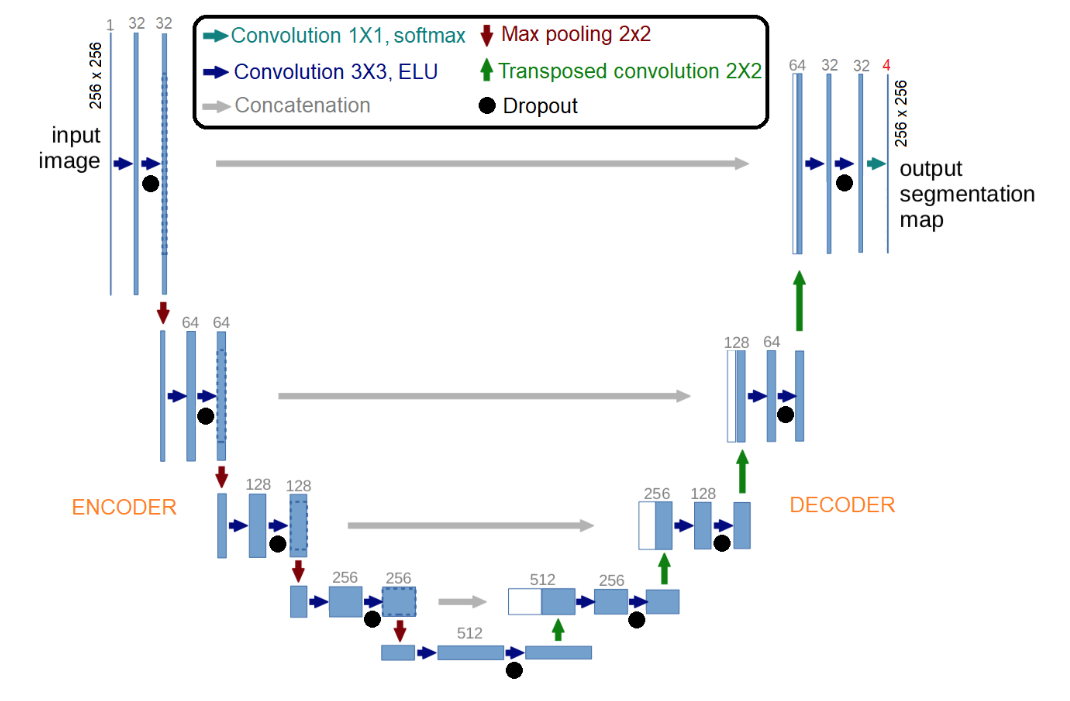

Citations:

Lizoain Cotanda, A. Application of machine learning techniques to images collected with Charge Coupled Devices to search for Dark Matter. (2020, September) [Online]. Available: http://hdl.handle.net/10902/20627.

GitHub link: https://github.com/aritzLizoain/CNN-Image-Segmentation
## Load Libraries

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Lambda
from keras import regularizers
from keras.callbacks import History
from keras.utils import plot_model
from glob import glob
from sklearn.model_selection import train_test_split
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Set directories

In [ ]:
# To use as input the denoised .tif images from previous step
# Otherwise set your own directory with .tif images here
model_input= output_folder
model_output= 'cnn_output_bioreactor'

## Set necessary functions

In [9]:

# Function to read .tif images from a specified directory
def load_images_from_folder(folder):
    images = []
    for filename in glob(os.path.join(folder, '*.tif')):
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

# Create masks using thresholding
def create_thresholded_masks(images, threshold_value=30):
    masks = []
    for img in images:
        # Create a mask using thresholding
        _, mask = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)
        masks.append(mask)
    return np.array(masks)

# Define the U-Net model
def unet(pretrained_weights=None, input_size=(256, 256, 1), activation='relu', dropout=0, loss='categorical_crossentropy', optimizer='adam', reg=0.01):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255)(inputs)
    
    # Contractive Path (ENCODER)
    c1 = Conv2D(32, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(s)
    c1 = Dropout(dropout)(c1)
    c1 = Conv2D(32, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(p1)
    c2 = Dropout(dropout)(c2)
    c2 = Conv2D(64, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(p2)
    c3 = Dropout(dropout)(c3)
    c3 = Conv2D(128, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(p3)
    c4 = Dropout(dropout)(c4)
    c4 = Conv2D(256, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(512, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(p4)
    c5 = Dropout(dropout)(c5)
    c5 = Conv2D(512, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c5)

    # Expansive Path (DECODER)
    u6 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(u6)
    c6 = Dropout(dropout)(c6)
    c6 = Conv2D(256, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c6)

    u7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(u7)
    c7 = Dropout(dropout)(c7)
    c7 = Conv2D(128, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c7)

    u8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(u8)
    c8 = Dropout(dropout)(c8)
    c8 = Conv2D(64, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c8)

    u9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(u9)
    c9 = Dropout(dropout)(c9)
    c9 = Conv2D(32, 3, activation=activation, kernel_initializer='he_normal', padding='same', kernel_regularizer=regularizers.l2(reg))(c9)

    outputs = Conv2D(2, 1, activation='softmax')(c9)  # Change to 2 classes: Background and Membrane

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Train the model and plot metrics
def train_model(model, train_images, train_masks, val_images, val_masks, epochs=50):
    history = History()
    history_callback = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=epochs, callbacks=[history])
    
    # Plot training & validation accuracy & loss
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_callback.history['accuracy'], label='Train Accuracy')
    plt.plot(history_callback.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_callback.history['loss'], label='Train Loss')
    plt.plot(history_callback.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return history

# Evaluate the model on test data
def evaluate_model(model, test_images, test_masks):
    test_outputs = model.predict(test_images)
    test_outputs_classes = np.argmax(test_outputs, axis=-1)
    test_masks_classes = np.argmax(test_masks, axis=-1)

    # Print unique classes in test outputs and masks
    print(f'Unique classes in test outputs: {np.unique(test_outputs_classes)}')
    print(f'Unique classes in test masks: {np.unique(test_masks_classes)}')

    # Generate classification report
    report = classification_report(
        test_masks_classes.flatten(),
        test_outputs_classes.flatten(),
        target_names=['Background', 'Membrane'],
        zero_division=0  # Handle zero division in case of no predicted samples
    )
    
    return test_outputs_classes, report

# Save outputs and plots
def save_outputs(test_images, test_masks, model, report, test_outputs_classes, output_dir='downloads'):
    os.makedirs(output_dir, exist_ok=True)

    # Save the model
    model.save(os.path.join(output_dir, 'unet_model.h5'))

    # Save classification report
    with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
        f.write(report)

    # Plot and save sample images
    for idx in range(3):  # Save 3 random images
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[idx].reshape(256, 256), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Masks
        plt.subplot(1, 3, 2)
        plt.imshow(test_masks[idx].reshape(256, 256), cmap='jet', alpha=0.5)
        plt.title('Applied Mask')
        plt.axis('off')

        # Predictions
        plt.subplot(1, 3, 3)
        plt.imshow(test_outputs_classes[idx], cmap='jet', alpha=0.5)
        plt.title('Predictions: Membrane vs No Membrane')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'test_image_{idx}.png'))
        plt.close()

## Train and test the models

Unique classes in training masks: [0 1]
Sample values from training masks:
[1 0 1 0 1 0 1 0 1 0]
Epoch 1/5
1/1 [==============================] - 21s 21s/step - loss: 59.5660 - accuracy: 0.6926 - val_loss: 56.4888 - val_accuracy: 0.6965
Epoch 2/5
1/1 [==============================] - 16s 16s/step - loss: 56.4899 - accuracy: 0.6952 - val_loss: 53.5449 - val_accuracy: 0.6974
Epoch 3/5
1/1 [==============================] - 21s 21s/step - loss: 53.5458 - accuracy: 0.6962 - val_loss: 50.7355 - val_accuracy: 0.6974
Epoch 4/5
1/1 [==============================] - 18s 18s/step - loss: 50.7363 - accuracy: 0.6963 - val_loss: 48.0589 - val_accuracy: 0.6972
Epoch 5/5
1/1 [==============================] - 16s 16s/step - loss: 48.0596 - accuracy: 0.6961 - val_loss: 45.5106 - val_accuracy: 0.6971


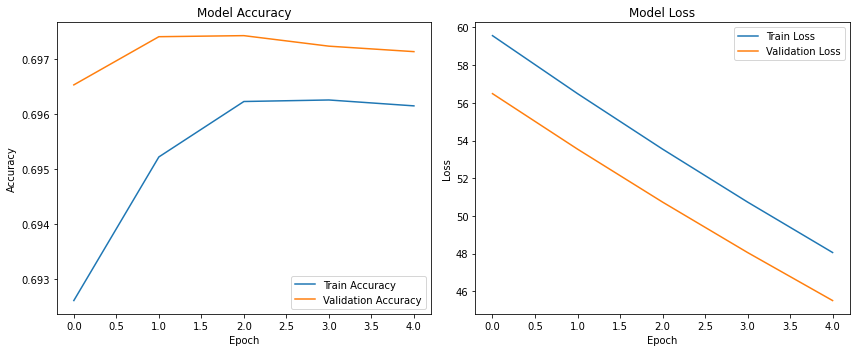

1/1 [==============================] - 3s 3s/step
Unique classes in test outputs: [0 1]
Unique classes in test masks: [0 1]
Unique classes in testing masks: [0 1]
Sample values from testing masks:
[1 0 1 0 1 0 1 0 1 0]


In [ ]:
#set number of epochs
num_epochs= 5

# Proceed to training
if __name__ == "__main__":
    # Load your images from folders
    image_folder = model_input  
    output_dir = model_output 

    # Load images
    images = load_images_from_folder(image_folder)

    # Resize images to (256, 256)
    resized_images = [cv2.resize(img, (256, 256)) for img in images]
    resized_images = np.array(resized_images)

    # Split into training and testing sets
    train_images, test_images = train_test_split(resized_images, test_size=0.2, random_state=42)

    # Create masks for training and testing
    train_masks = create_thresholded_masks(train_images)
    test_masks = create_thresholded_masks(test_images)

    # Reshape images and masks for model input
    train_images = train_images.reshape(-1, 256, 256, 1)  # Assuming input size is 256x256
    test_images = test_images.reshape(-1, 256, 256, 1)
    train_masks = train_masks.reshape(-1, 256, 256, 1)  # Same for masks
    test_masks = test_masks.reshape(-1, 256, 256, 1)

    # Convert masks to categorical
    train_masks_categorical = np.zeros((train_masks.shape[0], 256, 256, 2), dtype=np.uint8)
    test_masks_categorical = np.zeros((test_masks.shape[0], 256, 256, 2), dtype=np.uint8)

    # Set categorical masks for training
    train_masks_categorical[train_masks[:, :, :, 0] > 0, 1] = 1  # Membrane
    train_masks_categorical[train_masks[:, :, :, 0] == 0, 0] = 1  # Background

    # Set categorical masks for testing
    test_masks_categorical[test_masks[:, :, :, 0] > 0, 1] = 1  # Membrane
    test_masks_categorical[test_masks[:, :, :, 0] == 0, 0] = 1  # Background

    # Print unique classes and sample values for training masks
    print(f'Unique classes in training masks: {np.unique(train_masks_categorical)}')
    print('Sample values from training masks:')
    print(train_masks_categorical.flatten()[:10])  # Print first 10 values

    # Create and train model
    model = unet(input_size=(256, 256, 1))
    history = train_model(model, train_images, train_masks_categorical, test_images, test_masks_categorical, epochs=num_epochs)

    # Evaluate model
    test_outputs_classes, report = evaluate_model(model, test_images, test_masks_categorical)

    # Print unique classes and sample values for testing masks
    print(f'Unique classes in testing masks: {np.unique(test_masks_categorical)}')
    print('Sample values from testing masks:')
    print(test_masks_categorical.flatten()[:10])  # Print first 10 values

    # Save outputs
    save_outputs(test_images, test_masks, model, report, test_outputs_classes, output_dir)

# Extra Part. Only for testing

This part aims in testing already created NN models (e.g. .h5 models) in image stacks
## Import libraries and load dataset and model 

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.models import load_model
from glob import glob

# Choose your testing folder here or use the output of the denoising process
testing_input= output_folder
# Set the model directory
model_dir= 'cnn_output_bioreactor\\unet_model.h5'
# Set output directory
testing_output= 'cnn_output_bioreactor_test_only'


## Perform testing on dataset

In [16]:

# Function to read .tif images from a specified directory
def load_images_from_folder(folder):
    images = []
    for filename in glob(os.path.join(folder, '*.tif')):
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

# Create masks using thresholding
def create_thresholded_masks(images, threshold_value=30):
    masks = []
    for img in images:
        # Create a mask using thresholding
        _, mask = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)
        masks.append(mask)
    return np.array(masks)

# Evaluate the model on test data
def evaluate_model(model, test_images, test_masks):
    test_outputs = model.predict(test_images)
    test_outputs_classes = np.argmax(test_outputs, axis=-1)
    test_masks_classes = np.argmax(test_masks, axis=-1)

    # Print unique classes in test outputs and masks
    print(f'Unique classes in test outputs: {np.unique(test_outputs_classes)}')
    print(f'Unique classes in test masks: {np.unique(test_masks_classes)}')

    # Generate classification report
    report = classification_report(
        test_masks_classes.flatten(),
        test_outputs_classes.flatten(),
        target_names=['Background', 'Membrane'],
        zero_division=0  # Handle zero division in case of no predicted samples
    )
    
    return test_outputs_classes, report

# Save outputs and plots
def save_outputs(test_images, test_masks, report, test_outputs_classes, output_dir='downloads'):
    os.makedirs(output_dir, exist_ok=True)

    # Save classification report
    with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
        f.write(report)

    # Plot and save sample images
    random_indices = np.random.choice(test_images.shape[0], size=5, replace=False)  # Select 5 random images
    for idx in random_indices:
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[idx].reshape(256, 256), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Masks
        plt.subplot(1, 3, 2)
        plt.imshow(test_masks[idx].reshape(256, 256), cmap='jet', alpha=0.5)
        plt.title('Applied Mask')
        plt.axis('off')

        # Predictions
        plt.subplot(1, 3, 3)
        plt.imshow(test_outputs_classes[idx], cmap='jet', alpha=0.5)
        plt.title('Predictions: Membrane vs No Membrane')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'test_image_{idx}.png'))
        plt.close()

# Sample usage
if __name__ == "__main__":
    # Load your images from folders
    image_folder = testing_input  # Change this to your image folder path
    output_dir = testing_output  # Output directory for results

    # Load images
    images = load_images_from_folder(image_folder)

    # Resize images to (256, 256)
    resized_images = [cv2.resize(img, (256, 256)) for img in images]
    resized_images = np.array(resized_images)

    # Create masks for testing
    test_masks = create_thresholded_masks(resized_images)

    # Reshape images and masks for model input
    test_images = resized_images.reshape(-1, 256, 256, 1)  # Assuming input size is 256x256
    test_masks = test_masks.reshape(-1, 256, 256, 1)  # Same for masks

    # Convert masks to categorical
    test_masks_categorical = np.zeros((test_masks.shape[0], 256, 256, 2), dtype=np.uint8)
    test_masks_categorical[test_masks[:, :, :, 0] > 0, 1] = 1  # Membrane
    test_masks_categorical[test_masks[:, :, :, 0] == 0, 0] = 1  # Background

    # Print unique classes and sample values for testing masks
    print(f'Unique classes in testing masks: {np.unique(test_masks_categorical)}')
    print('Sample values from testing masks:')
    print(test_masks_categorical.flatten()[:10])  # Print first 10 values

    # Load pre-trained model
    model = load_model(model_dir)

    # Evaluate model
    test_outputs_classes, report = evaluate_model(model, test_images, test_masks_categorical)

    # Save outputs
    save_outputs(test_images, test_masks, report, test_outputs_classes, output_dir)

Unique classes in testing masks: [0 1]
Sample values from testing masks:
[1 0 1 0 1 0 1 0 1 0]
1/1 [==============================] - 4s 4s/step
Unique classes in test outputs: [0 1]
Unique classes in test masks: [0 1]
